In [26]:

from __future__ import print_function
from __future__ import division

from ast import literal_eval

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
import time
import h5py
import argparse
import os
import sys
import pandas as pd

import masked_networks
from tf_plus import learning_phase, batchnorm_learning_phase
from tf_plus import sess_run_dict, add_classification_losses
from tf_plus import summarize_weights
from train_supermask import make_parser, read_input_data, \
    init_model, load_initial_weights, split_and_shape
import matplotlib.pyplot as plt


In [27]:
def get_test_accs (run_dir):
    test_accs = []
    for filename in os.listdir(run_dir):
        if 'tfevents' in filename:
            for e in tf.compat.v1.train.summary_iterator(os.path.join(
                run_dir, filename
            )):
                for v in e.summary.value:
                    if v.tag == 'eval_test_acc':
                        test_accs.append(v.simple_value)
    return np.array(test_accs)

In [28]:
# run_dir = "./results/iter_lot_fc_orig/learned_supermasks_pre_trained_55_epochs_seed_10_0/run1"
cols = ['seed', 'regular_epochs', 'supermask_epochs', 'experiment_name', 'has_supermask', 'has_lth','test_accuracy']
df = pd.DataFrame(columns = cols)
for epochs in [11, 22, 33, 44, 55]:
    for seed in [i for i in range(1, 11)]:
        run_dir = "./results/iter_lot_fc_orig/learned_supermasks_pre_trained_{}_epochs_seed_{}_0/run1".format(epochs, seed)
        df = df.append({'seed':seed, 'regular_epochs':epochs, 'supermask_epochs':500, 'experiment_name':'pretrained_supermask', 'has_supermask': 1, 'has_lth': 0, 'test_accuracy': np.max(get_test_accs(run_dir))}, ignore_index=True)

print(df.head())
# df = df.append({'seed':0, 'epochs':0, 'experiment_number':0, 'has_supermask':0, 'has_lth':0}, ignore_index=True)
# df = df.append({'seed':1, 'epochs':0, 'experiment_number':0, 'has_supermask':0, 'has_lth':0}, ignore_index=True)
df = df.astype({'seed':'int32', 'regular_epochs':'int32', 'supermask_epochs':'int32', 'experiment_name':str, 'has_supermask':'int32', 'has_lth':'bool', 'has_lth':'int32'})
print(df.dtypes)
# df = df.astype({'regular_epochs':'int32'}).dtypes
# df = df.astype({'supermask_epochs':'int32'}).dtypes
# df = df.astype({'has_supermask':'bool'}).dtypes
# df = df.astype({'has_lth':'bool'}).dtypes




  seed regular_epochs supermask_epochs       experiment_name has_supermask  \
0    1             11              500  pretrained_supermask             1   
1    2             11              500  pretrained_supermask             1   
2    3             11              500  pretrained_supermask             1   
3    4             11              500  pretrained_supermask             1   
4    5             11              500  pretrained_supermask             1   

  has_lth  test_accuracy  
0       0         0.9504  
1       0         0.9490  
2       0         0.9492  
3       0         0.9473  
4       0         0.9509  
seed                  int32
regular_epochs        int32
supermask_epochs      int32
experiment_name      object
has_supermask         int32
has_lth               int32
test_accuracy       float64
dtype: object


In [29]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [30]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))
    

In [31]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [32]:
# X = df['regular_epochs']
X = df.drop(['seed', 'test_accuracy', 'experiment_name'], axis=1).astype(int)
y = df['test_accuracy']

xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

mse=mean_squared_error(y, y_pred)

print(np.sqrt(mse))

[22:33:18] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
0.0013632051775060168


In [33]:
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb_model)
plt.show()

ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.

                  regular_epochs  supermask_epochs  has_supermask  has_lth  \
regular_epochs          1.000000               NaN            NaN      NaN   
supermask_epochs             NaN               NaN            NaN      NaN   
has_supermask                NaN               NaN            NaN      NaN   
has_lth                      NaN               NaN            NaN      NaN   
test_accuracy          -0.025937               NaN            NaN      NaN   

                  test_accuracy  
regular_epochs        -0.025937  
supermask_epochs            NaN  
has_supermask               NaN  
has_lth                     NaN  
test_accuracy          1.000000  


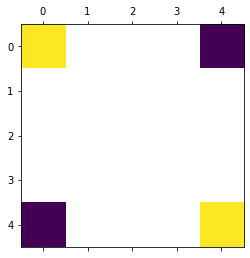

In [25]:
import matplotlib.pyplot as plt
#df = df.drop(['seed'], axis=1)
print(df.corr())
plt.matshow(df.corr())
plt.show()